# Import Modules & Data

In [68]:
import math as mt
from scipy.stats import norm
import statsmodels.stats.multitest
import statistics
from numpy import sqrt, abs, round
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [3]:
plt.style.use("~/custom_stock.mplstyle")
matplotlib.rcParams.update({'errorbar.capsize': 3})

In [4]:
df=pd.read_csv('data.csv.gz', compression='gzip')

In [5]:
#country='Saudi Arabia'
#df=df[df['country']==country]

# Clean and Transform Data

In [6]:
# make dates correct dtypes
cols = ['event_timestamp', 'user_first_touch_timestamp']

for col in cols:
    df[col] = pd.to_datetime(df[col])
    
# Add a column specifying whether an event is a useful 'engagement' or not
# create a list of our conditions
conditions = [
    (df['eventName'] == 'save_location'),
    (df['eventName'] == 'search'),
    (df['eventName'] == 'search_3wa'),
    (df['eventName'] == 'share'),
    (df['eventName'] == 'sign_up'),
    (df['eventName'] == 'directions'),
    
    ]
# create a list of the values we want to assign for each condition
values = ['Engagement', 'Engagement', 'Engagement', 'Engagement', 'Engagement', 'Engagement']
# create a new column and use np.select to assign values to it using our lists as arguments
df['Engaged'] = np.select(conditions, values)
df['Engaged'] = df['Engaged'].astype(str).replace('0', np.nan)

In [7]:
# Add column for difference between first touch and event timestamp
df['time_since_first_touch'] = df['event_timestamp'] - df['user_first_touch_timestamp']
df['days_since_first_touch'] = (df['event_timestamp'].max() - df['user_first_touch_timestamp']).dt.days

# Create separate dataframes for each group
variant_group = df[df['experimentVariant'] == 'Variant A']
control_group = df[df['experimentVariant'] == 'Control group']

# Return df with test group sizes
test_group_size = pd.DataFrame(df.groupby('experimentVariant')['random_user_id'].nunique())
test_group_size.rename(columns={'random_user_id':'count_unique_users'}, inplace=True)

# Exploratory data analysis

__Summary of the data:__ <br />
    1. There are 74941 unique users in the data set <br />
    2. We have two categories, mobile and table <br />
    3. We are only looking at IOS operating systems <br />
    4. We have 171 countries. The UK has by far the most unique users, 55k, followed by the US with 5k <br />
    5. We have a control group and a variant group <br />
    6. There are 11 unique events in the dataset, carousel_next is the variant treatment <br />
    7. The data was collected between 20/08/2019 and 01/09/2019 <br />

In [8]:
test=df.groupby('country')['random_user_id'].nunique()
test.sort_values(ascending=False).head(10)

country
United Kingdom    55206
United States      5276
South Africa       1551
Saudi Arabia       1249
Canada              983
Australia           904
Japan               896
Denmark             776
Germany             716
Russia              635
Name: random_user_id, dtype: int64

### Overview of the data

In [9]:
unique_users_per_group = df.groupby('experimentVariant')['random_user_id'].nunique()
unique_users_per_group

experimentVariant
Control group    37671
Variant A        37360
Name: random_user_id, dtype: int64

In [10]:
df.groupby('eventName')['random_user_id'].nunique().sort_values(ascending=False)

eventName
tutorial_step1      73406
search              35798
tutorial_dismiss    32486
tutorial_step4      28865
carousel_next       27872
directions           7645
sign_up              5526
search_3wa           4117
save_location        3773
menu_settings        3548
share                2312
Name: random_user_id, dtype: int64

In [11]:
df.event_timestamp.min()

Timestamp('2019-08-20 13:50:52.944000+0000', tz='UTC')

In [12]:
df.event_timestamp.max()

Timestamp('2019-09-01 22:59:57.392006+0000', tz='UTC')

In [13]:
df.groupby(['experimentVariant', 'eventName'])['random_user_id'].nunique()

experimentVariant  eventName       
Control group      directions           3848
                   menu_settings        1808
                   save_location        1705
                   search              17622
                   search_3wa           2078
                   share                1036
                   sign_up              2526
                   tutorial_dismiss    16562
                   tutorial_step1      36857
                   tutorial_step4      14138
Variant A          carousel_next       27872
                   directions           3801
                   menu_settings        1740
                   save_location        2070
                   search              18200
                   search_3wa           2040
                   share                1276
                   sign_up              3000
                   tutorial_dismiss    15931
                   tutorial_step1      36607
                   tutorial_step4      14735
Name: random_user_i

From the above we can see that the only difference between the two experiment groups are that the variant has an additional event, called carousel_next

### Assignment by Country

In [14]:
country_split = pd.DataFrame(df.groupby(['country', 'experimentVariant'])['random_user_id'].nunique()).reset_index()
country_split=country_split.pivot(columns='experimentVariant', values='random_user_id', index='country')
country_split.reset_index(inplace=True)
country_split['total'] = country_split['Control group'] + country_split['Variant A']
country_split=country_split.sort_values(ascending=False, by='total')
country_other=country_split.tail(161)
country_other['country']='Other'
country_other=country_other.groupby('country')[['Control group', 'Variant A']].sum()
country_other.reset_index(inplace=True)
country_summary=country_split.head(10).append(country_other)

### Conversion to an Engagement by Country

In [15]:
cvr_by_country=pd.DataFrame(df.groupby(['country', 'experimentVariant'])['random_user_id'].nunique())
foo = df[df['Engaged'] =='Engagement']
foo=pd.DataFrame(foo.groupby(['country', 'experimentVariant'])['random_user_id'].nunique())
cvr_by_country = cvr_by_country.join(foo, rsuffix='_engagements')
cvr_by_country['cvr'] = cvr_by_country['random_user_id_engagements']/cvr_by_country['random_user_id'] 
cvr_by_country = cvr_by_country.sort_values(by='random_user_id_engagements', ascending=False)
cvr_by_country.reset_index(inplace=True)

In [16]:
cvr_by_country=cvr_by_country[cvr_by_country['country'].isin(['United Kingdom',
                                                                'United States',
                                                                'South Africa',
                                                                'Saudi Arabia',
                                                                'Canada',
                                                                'Japan',
                                                                'Australia',
                                                                'Denmark',
                                                                'Germany',
                                                                'Russia']
)]

cvr_by_country=cvr_by_country.pivot(columns='experimentVariant', index='country', values='cvr')
cvr_by_country=cvr_by_country*100

### First touches over time by assignment group

In [17]:
df['first_touch_date'] = pd.to_datetime(df['user_first_touch_timestamp']).dt.date
first_touch_date = pd.DataFrame(df.groupby(['experimentVariant', 'first_touch_date'])['random_user_id'].nunique())
first_touch_date.reset_index(inplace=True)
first_touch_date=first_touch_date.pivot(columns='experimentVariant', index='first_touch_date', values='random_user_id')

### Assigment by device

In [18]:
device = pd.DataFrame(df.groupby(['experimentVariant', 'category'])['random_user_id'].nunique())
device.reset_index(inplace=True)
device=device.pivot(columns='experimentVariant', index='category', values='random_user_id')

### Engagement with the Carousel

In [19]:
variant_group['carousel_engagement'] = [1 if i == 'carousel_next' else 0 for i in variant_group.eventName]
carousel_engagement_df = pd.DataFrame(variant_group.groupby(['random_user_id'])['carousel_engagement'].sum())
carousel_engagement_df=carousel_engagement_df.sort_values(by='carousel_engagement', ascending=False)
carousel_engagement_df.reset_index(inplace=True)
carousel_engagement_summary=carousel_engagement_df.groupby('carousel_engagement')['random_user_id'].count()

In [20]:
carousel_engagement_df['carousel_engagement_type'] = ['Yes' if i > 0 else 'No' for i in carousel_engagement_df.carousel_engagement]
variant_group=variant_group.merge(carousel_engagement_df, how='left', on='random_user_id')
engagement_by_carousel_summary=variant_group.groupby(['carousel_engagement_type']).agg({'random_user_id':'nunique', 'Engaged':'count'})
engagement_by_carousel_summary['engagement_rate']= engagement_by_carousel_summary['Engaged'] / engagement_by_carousel_summary['random_user_id']
engagement_by_carousel_summary.rename(columns={'random_user_id':'count_users', 'engagement_rate': 'engagement_rate', 'Engaged':'count_engagements'}, inplace=True)

In [21]:
engagement_by_carousel_summary

,count_users,count_engagements,engagement_rate
carousel_engagement_type,,,
No,9488,9286,0.978710
Yes,27872,35953,1.289933


In [22]:
# Evidence that those who go through the carousel at least once are more likely to have a greater number of engagements in the app. This might be intent, or effect.

### Plot Findings

In [23]:
plt.rcParams["figure.figsize"]=28, 30

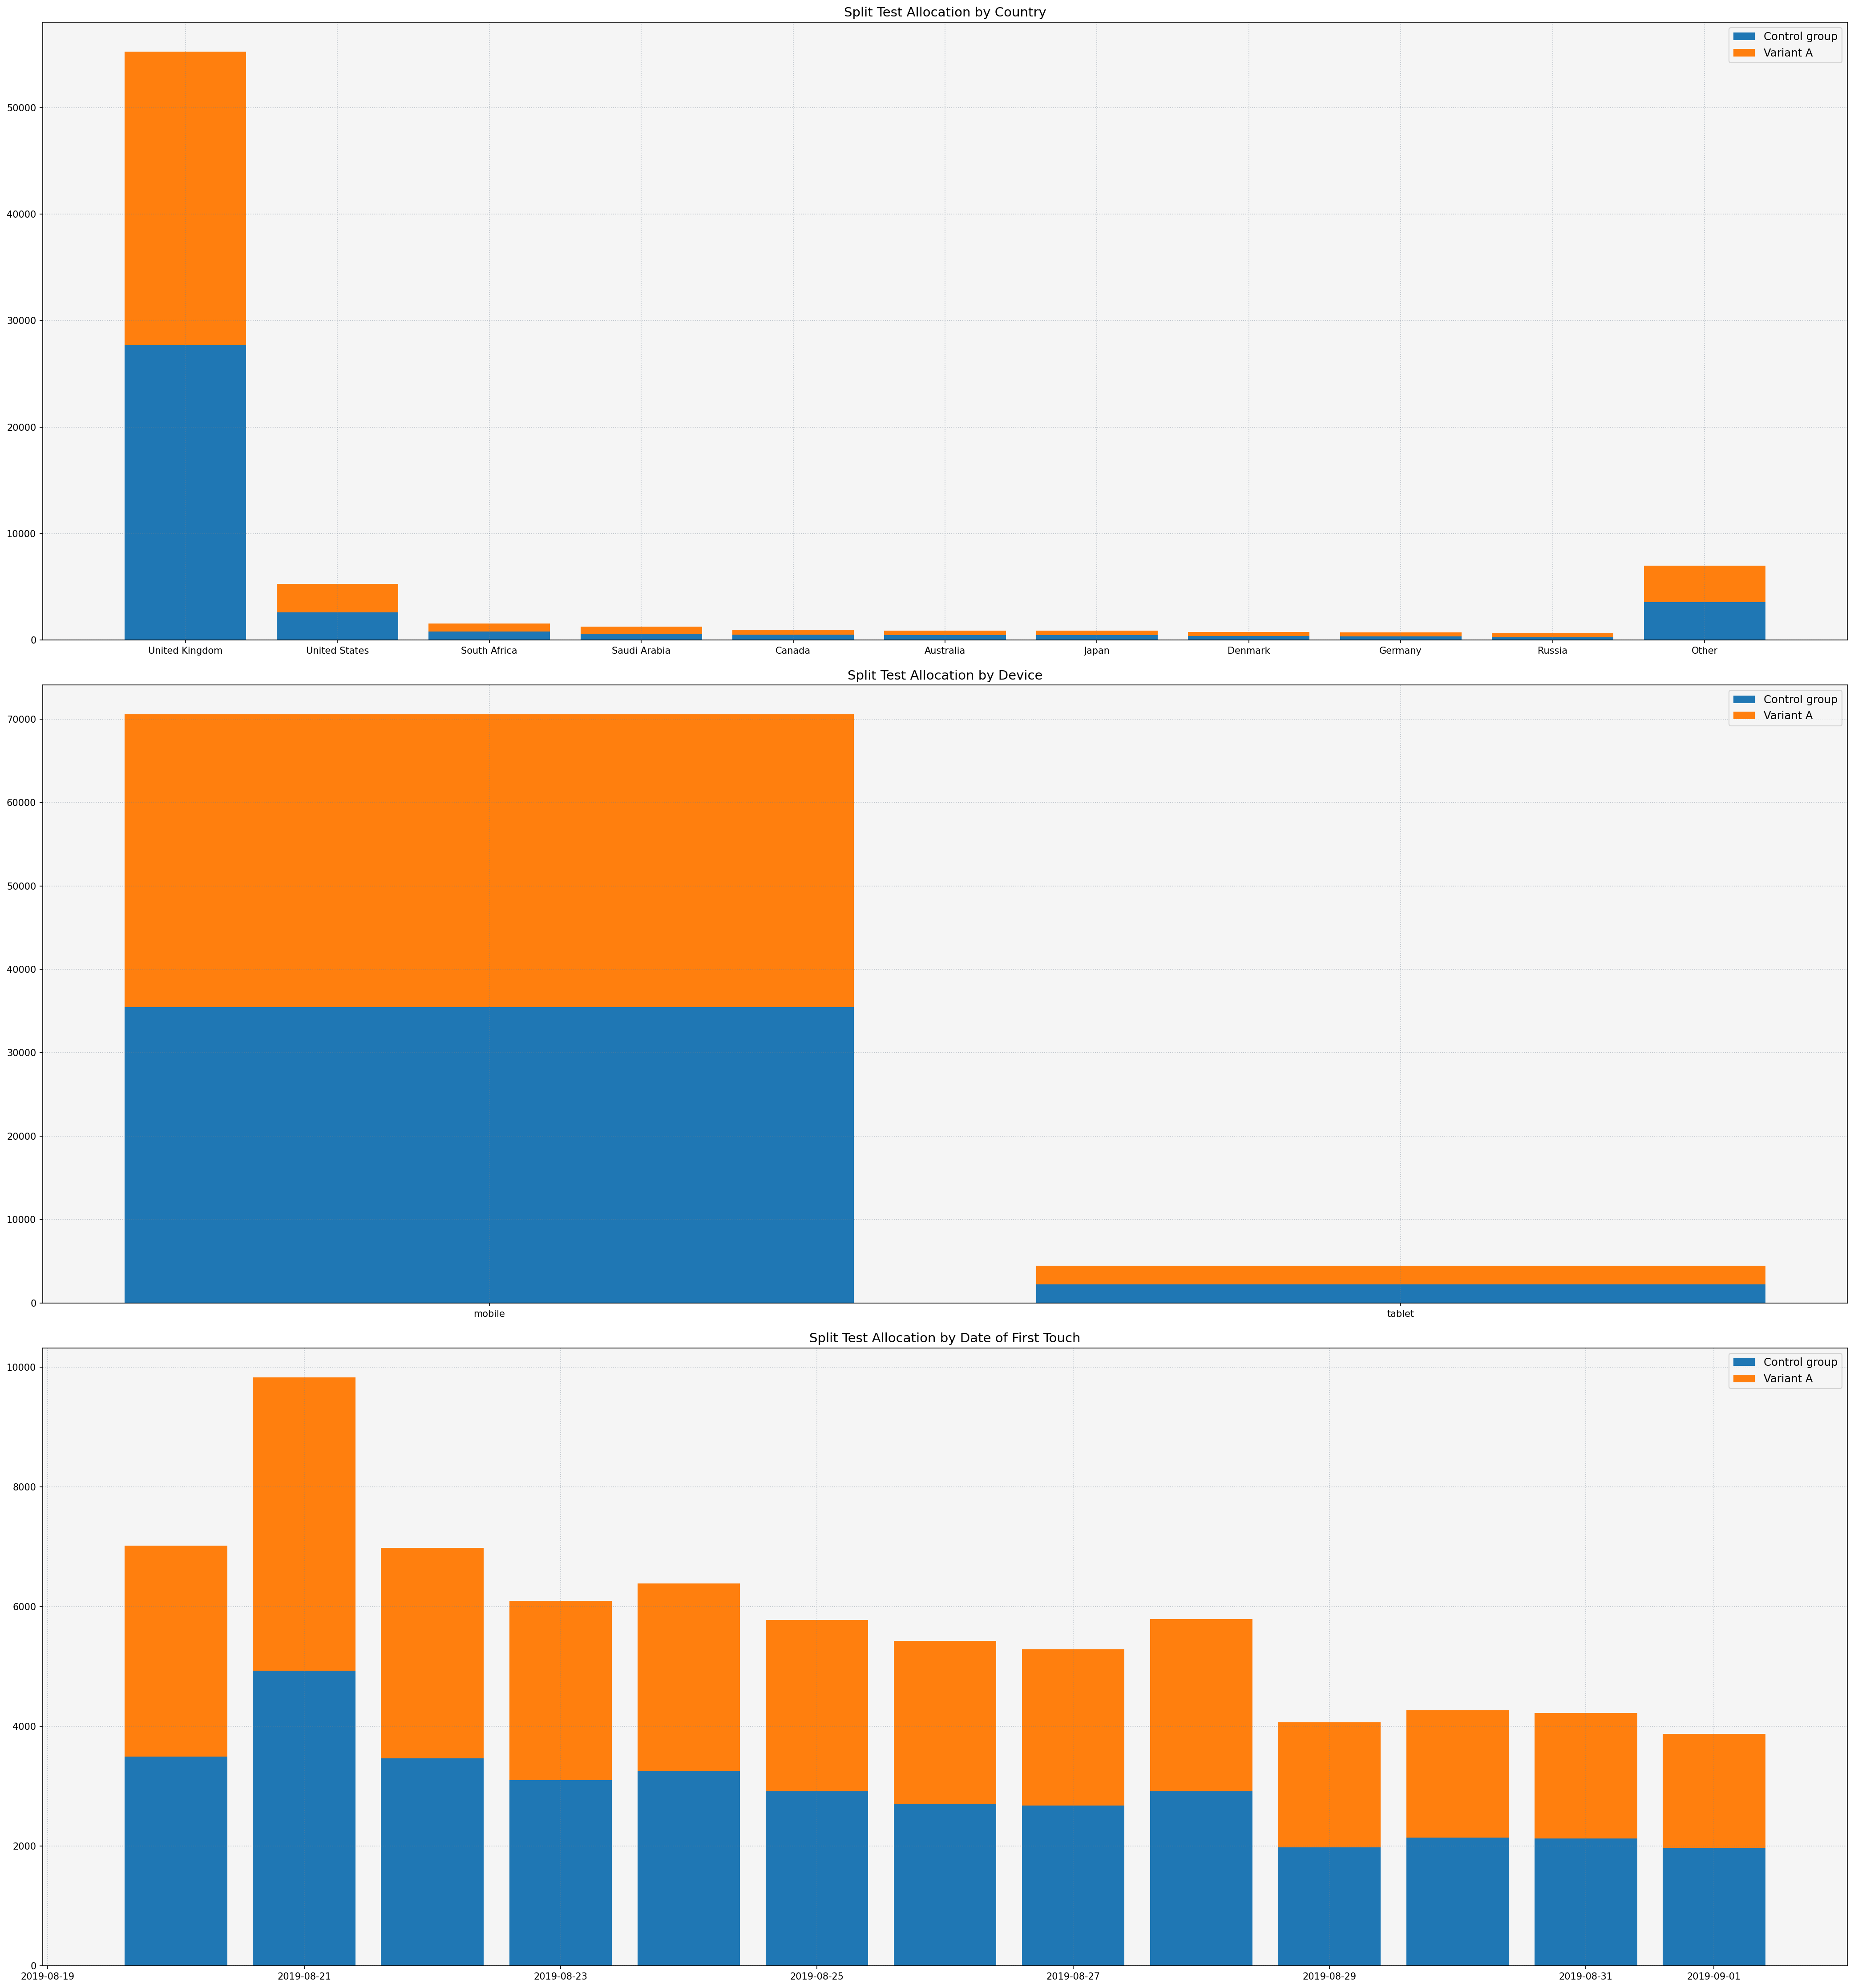

In [24]:
fig, axs = plt.subplots(nrows=3,ncols=1)

axs[0].bar(country_summary.country,
           country_summary['Control group'],
           label='Control group'
          )
axs[0].bar(country_summary.country,
           country_summary['Variant A'],
           bottom = country_summary['Control group'],
           label='Variant A'
          )

axs[1].bar(device.index,
           device['Control group'],
            label='Control group'
          )
axs[1].bar(device.index,
           device['Variant A'],
           bottom = device['Control group'],
           label='Variant A'
          )

axs[2].bar(first_touch_date.index,
           first_touch_date['Control group'],
           label='Control group'
          )
axs[2].bar(first_touch_date.index,
           first_touch_date['Variant A'],
           bottom = first_touch_date['Control group'],
           label='Variant A'
          )

axs[0].set_title('Split Test Allocation by Country')
axs[1].set_title('Split Test Allocation by Device')
axs[2].set_title('Split Test Allocation by Date of First Touch')

axs[0].legend()
axs[1].legend()
axs[2].legend()


plt.tight_layout(h_pad=3)

<AxesSubplot:title={'center':'Number of Carousel Engagements per User'}, xlabel='Count of Engagements', ylabel='Count Users'>

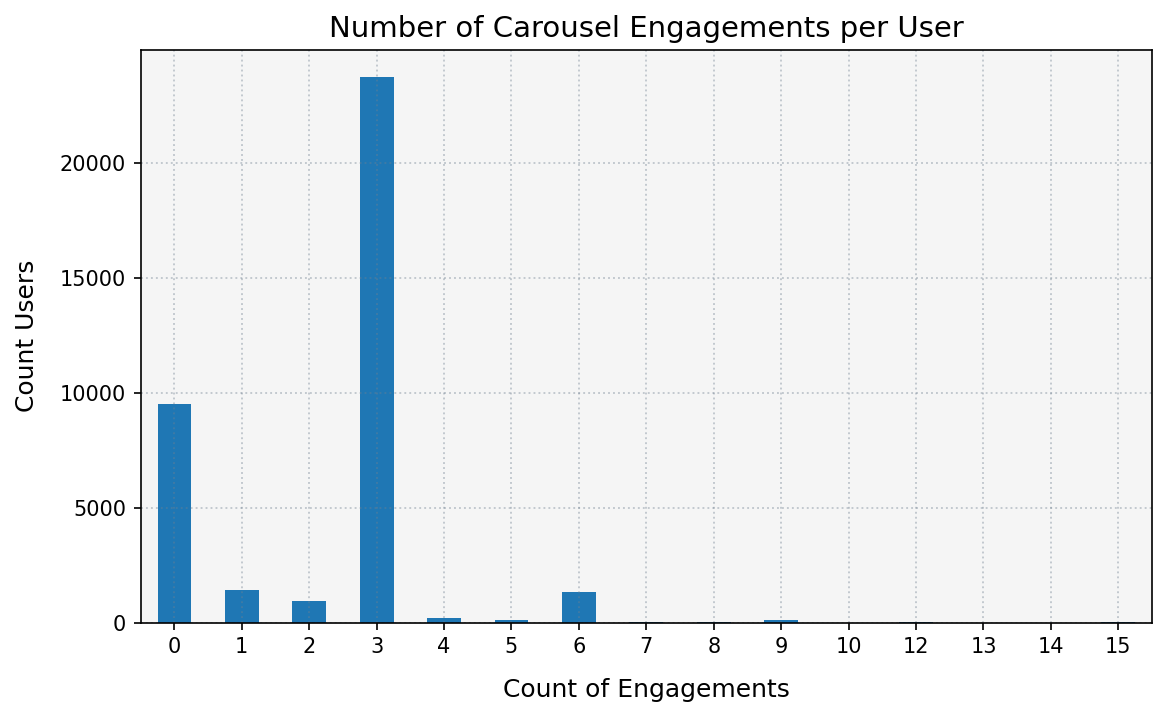

In [69]:
plt.rcParams["figure.figsize"]=8, 5

carousel_engagement_summary.plot(kind='bar',
                                 title = 'Number of Carousel Engagements per User',
                                 xlabel = "Count of Engagements",
                                 ylabel = 'Count Users',
                                 rot=0)

<AxesSubplot:title={'center':'Unique User Conversion to an Engagement by Country (Top 10 countries by Total Unique Users)'}, xlabel='country', ylabel='%'>

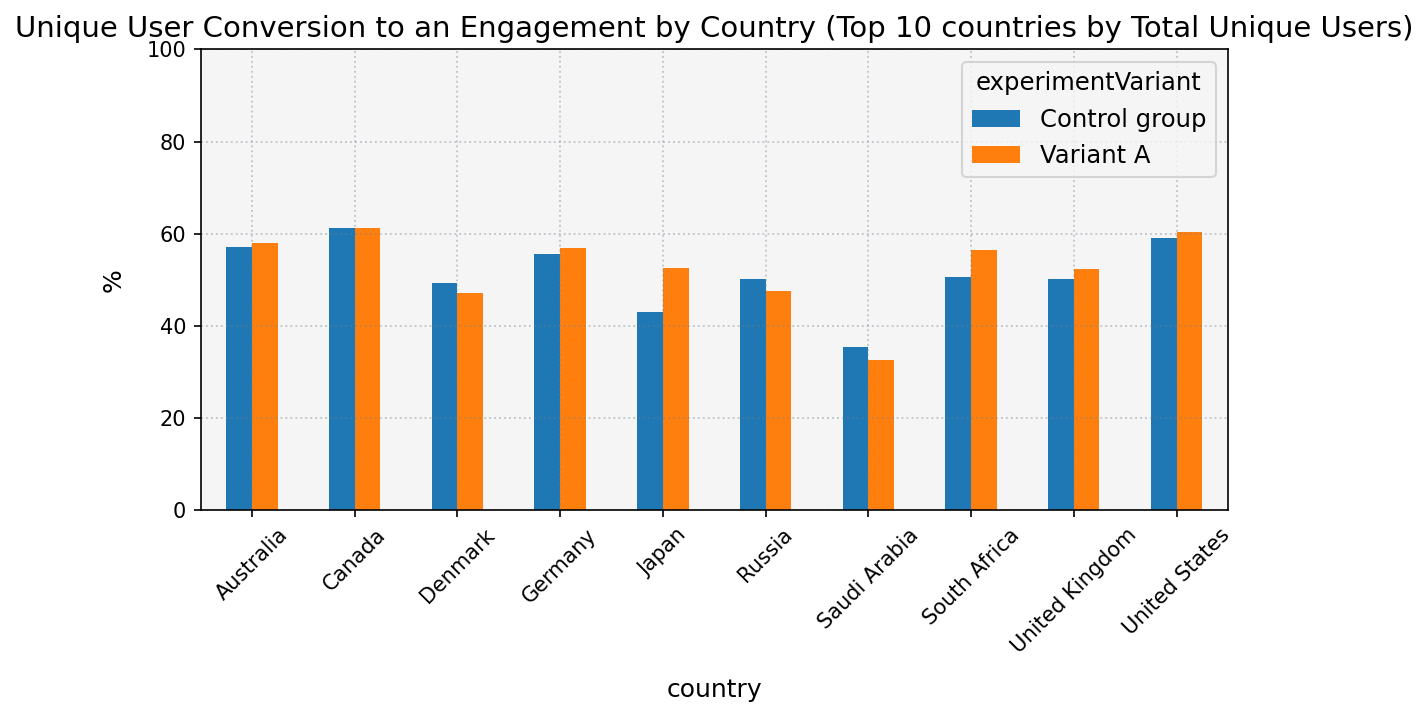

In [26]:
cvr_by_country.plot(kind='bar', 
          stacked=False,
          title='Unique User Conversion to an Engagement by Country (Top 10 countries by Total Unique Users)',
          ylabel='%',
          ylim=(0,100),
          rot=45
         )

# AB Analysis

In [27]:
from functions import *

In [28]:
# Conversion to 'Signup'
signup_conversion = create_summary_df(df, test_group_size, 'sign_up')
summary_confidence_levels_two_proportions(signup_conversion, 'sign_up')

,count_unique_users,sign_up,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,2526,0.067054,0.069580,0.064528,6.958000,6.452846,6.705423,0.505154
Variant A,37360,3000,0.080300,0.083055,0.077544,8.305549,7.754408,8.029979,0.551141


In [29]:
# Conversion to 'Save Location'
save_location_conversion = create_summary_df(df, test_group_size, 'save_location')
summary_confidence_levels_two_proportions(save_location_conversion, 'save_location')

,count_unique_users,save_location,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,1705,0.045260,0.047359,0.043161,4.735948,4.316108,4.526028,0.419840
Variant A,37360,2070,0.055407,0.057727,0.053087,5.772669,5.308702,5.540685,0.463967


In [30]:
# Conversion to 'directions'
directions_conversion = create_summary_df(df, test_group_size, 'directions')
summary_confidence_levels_two_proportions(directions_conversion, 'directions')

,count_unique_users,directions,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,3848,0.102148,0.105206,0.099089,10.520576,9.908932,10.214754,0.611644
Variant A,37360,3801,0.101740,0.104805,0.098674,10.480531,9.867434,10.173983,0.613097


In [31]:
# Conversion to 'Search_3wa'
search3wa_conversion = create_summary_df(df, test_group_size, 'search_3wa')
summary_confidence_levels_two_proportions(search3wa_conversion, 'search_3wa')

,count_unique_users,search_3wa,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,2078,0.055162,0.057467,0.052856,5.746722,5.285637,5.516180,0.461084
Variant A,37360,2040,0.054604,0.056908,0.052300,5.690779,5.229991,5.460385,0.460788


In [32]:
# Conversion to 'Search'
search_conversion = create_summary_df(df, test_group_size, 'search')
summary_confidence_levels_two_proportions(search_conversion, 'search')

,count_unique_users,search,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,17622,0.467787,0.472826,0.462748,47.282560,46.274818,46.778689,1.007742
Variant A,37360,18200,0.487152,0.492221,0.482084,49.222053,48.208354,48.715203,1.013699


In [33]:
# Conversion to 'Share'
share_conversion = create_summary_df(df, test_group_size, 'share')
summary_confidence_levels_two_proportions(share_conversion, 'share')

,count_unique_users,share,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,1036,0.027501,0.029153,0.025850,2.915274,2.584978,2.750126,0.330296
Variant A,37360,1276,0.034154,0.035996,0.032312,3.599592,3.231244,3.415418,0.368348


In [34]:
# Conversion to 'Engagement'
engaged = df[df['Engaged'] == 'Engagement']
engaged_unique = pd.DataFrame(engaged.groupby(['experimentVariant'])['random_user_id'].nunique())
engaged_unique.rename(columns={'random_user_id':'Engaged'}, inplace=True)
unique_engagement_conversion = test_group_size.join(engaged_unique)
summary_confidence_levels_two_proportions(unique_engagement_conversion, 'Engaged')

,count_unique_users,Engaged,Conversion_Proportion,UB,LB,UB_%,LB_%,Conversion_Proportion_%,yerr
experimentVariant,,,,,,,,,
Control group,37671,19217,0.510127,0.515175,0.505079,51.517532,50.507899,51.012715,1.009633
Variant A,37360,19874,0.531959,0.537019,0.526900,53.701912,52.689951,53.195931,1.011961


In [35]:
# Engagement by type of engagements
engaged.groupby(['eventName', 'experimentVariant'])['random_user_id'].count()

eventName      experimentVariant
directions     Control group         5232
               Variant A             5155
save_location  Control group         4002
               Variant A             4654
search         Control group        27359
               Variant A            27696
search_3wa     Control group         3265
               Variant A             3194
share          Control group         1246
               Variant A             1538
sign_up        Control group         2527
               Variant A             3002
Name: random_user_id, dtype: int64

In [36]:
# Create df to plot distribution of unique users by engagement
engagement_distribution=pd.DataFrame(df.groupby(['random_user_id','experimentVariant'])['Engaged'].count())
engagement_distribution.reset_index(inplace=True)
engagement_distribution=pd.DataFrame(engagement_distribution.groupby(['Engaged', 'experimentVariant'])['random_user_id'].count())
engagement_distribution.reset_index(inplace=True)
engagement_distribution=engagement_distribution.pivot(index='Engaged', columns='experimentVariant', values='random_user_id')

# Mean number of engagements per user
engagements=pd.DataFrame(df.groupby(['random_user_id','experimentVariant'])['Engaged'].count())
engagements=engagements.reset_index()
engagements=engagements.groupby('experimentVariant').agg({'Engaged':['mean', 'std']})
engagements=engagements.droplevel(0, axis=1)
engagements=engagements.join(test_group_size)
engagements.reset_index(inplace=True)
summary_confidence_levels_two_means(engagements,'mean')

,experimentVariant,mean,std,count_unique_users,UB,LB,yerr
0,Control group,1.158212,2.166025,37671,1.180085,1.136339,0.043747
1,Variant A,1.210894,2.178873,37360,1.232989,1.188799,0.044189


In [37]:
# Find distribution of sampling means for engagement in whole sample
engagements_histogram=pd.DataFrame(df.groupby(['random_user_id'])['Engaged'].count())
repeated_sample = engagements_histogram
engagement_sample_mean_dist=repeated_sample_means_distribution(repeated_sample)

In [38]:
# Find distribution of sampling means for engagement split by experimentVariant
df_control = df[df['experimentVariant']=='Control group']
df_treat= df[df['experimentVariant']=='Variant A']
control_group_histogram=pd.DataFrame(df_control.groupby(['experimentVariant','random_user_id'])['Engaged'].count())
treat_group_histogram=pd.DataFrame(df_treat.groupby(['experimentVariant','random_user_id'])['Engaged'].count())

repeated_sample_control = control_group_histogram
control_engagement_sample_mean_dist=repeated_sample_means_distribution(repeated_sample_control)

repeated_sample_treat = treat_group_histogram
treatment_engagement_sample_mean_dist=repeated_sample_means_distribution(repeated_sample_treat)

In [39]:
# Customer Retention - as measured by total mean number of days active
# Create df to plot distribution of unique users by active days
df['event_date'] = pd.to_datetime(df['event_timestamp']).dt.date
days_active = pd.DataFrame(df.groupby(['random_user_id', 'experimentVariant'])['event_date'].nunique())
days_active.reset_index(inplace=True)
days_active_plot=pd.DataFrame(days_active.groupby(['event_date', 'experimentVariant'])['random_user_id'].count())
days_active_plot.reset_index(inplace=True)
days_active_plot=days_active_plot.pivot(index='event_date', columns='experimentVariant', values='random_user_id')



In [40]:
# Find mean days and confidence levels
joined_retention=days_active.groupby('experimentVariant').agg({'event_date':['mean', 'std']})
joined_retention=joined_retention.droplevel(0, axis=1)
joined_retention=joined_retention.join(test_group_size)
joined_retention.reset_index(inplace=True)
summary_confidence_levels_two_means(joined_retention,'mean')

,experimentVariant,mean,std,count_unique_users,UB,LB,yerr
0,Control group,1.066125,0.251899,37671,1.068669,1.063581,0.005088
1,Variant A,1.067372,0.255533,37360,1.069963,1.064780,0.005182


In [41]:
# Find distribution of sampling means for retention in whole sample
repeated_sample = days_active
retention_sample_mean_dist=repeated_sample_means_distribution(repeated_sample)

### AB Test Results

In [42]:
significance_test_difference_between_two_proportions(signup_conversion, 'sign_up')

The change due to the sign_up experiment is 1.32 % points
Confidence Interval of difference: [ 0.0095 , 0.0169 ]
p-value is 1.8898216325169415e-12
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [43]:
significance_test_difference_between_two_proportions(unique_engagement_conversion, 'Engaged')

The change due to the Engaged experiment is 2.18 % points
Confidence Interval of difference: [ 0.0147 , 0.028900000000000002 ]
p-value is 1.0789736881733347e-09
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [44]:
significance_test_difference_between_two_proportions(search_conversion, 'search')

The change due to the search experiment is 1.94 % points
Confidence Interval of difference: [ 0.0123 , 0.026500000000000003 ]
p-value is 5.4865027521167065e-08
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [45]:
significance_test_difference_between_two_proportions(share_conversion, 'share')

The change due to the share experiment is 0.67 % points
Confidence Interval of difference: [ 0.004200000000000001 , 0.0092 ]
p-value is 6.726720813698961e-08
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [46]:
significance_test_difference_between_two_proportions(save_location_conversion, 'save_location')

The change due to the save_location experiment is 1.01 % points
Confidence Interval of difference: [ 0.006999999999999999 , 0.0132 ]
p-value is 1.0261813621070814e-10
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [47]:
significance_test_difference_between_two_proportions(directions_conversion, 'directions')

The change due to the directions experiment is -0.04 % points
Confidence Interval of difference: [ -0.0047 , 0.0039 ]
p-value is 0.42679227213757487
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [48]:
significance_test_difference_between_two_proportions(search3wa_conversion, 'search_3wa')

The change due to the search_3wa experiment is -0.06 % points
Confidence Interval of difference: [ -0.0039 , 0.0027 ]
p-value is 0.36861897651859576
The change is statistically significant if the CI doesn't include 0.
A p-value of 0.05 indicates that you are willing to accept a 5% chance that you are wrong when you reject the null hypothesis.


In [49]:
significance_test_difference_between_two_means(joined_retention)

p-value is 0.250546641299213
The change due to the experiment in retention is 0.12 %
Confidence Interval of difference: [ -0.0024000000000000002 , 0.0048 ]
The change is statistically significant if the CI doesn't include 0.


In [50]:
significance_test_difference_between_two_means(engagements)

p-value is 0.0004481810415241094
The change due to the experiment in retention is 5.27 %
Confidence Interval of difference: [ 0.021599999999999998 , 0.0838 ]
The change is statistically significant if the CI doesn't include 0.


# Plot Results

In [53]:
x, p = fit_norm_dist(engagement_sample_mean_dist, 'Engaged')
x_r, p_r = fit_norm_dist(retention_sample_mean_dist, 'event_date')
engagement_distribution_top_12 = engagement_distribution.head(12)

In [54]:
plt.rcParams["figure.figsize"]=26, 80

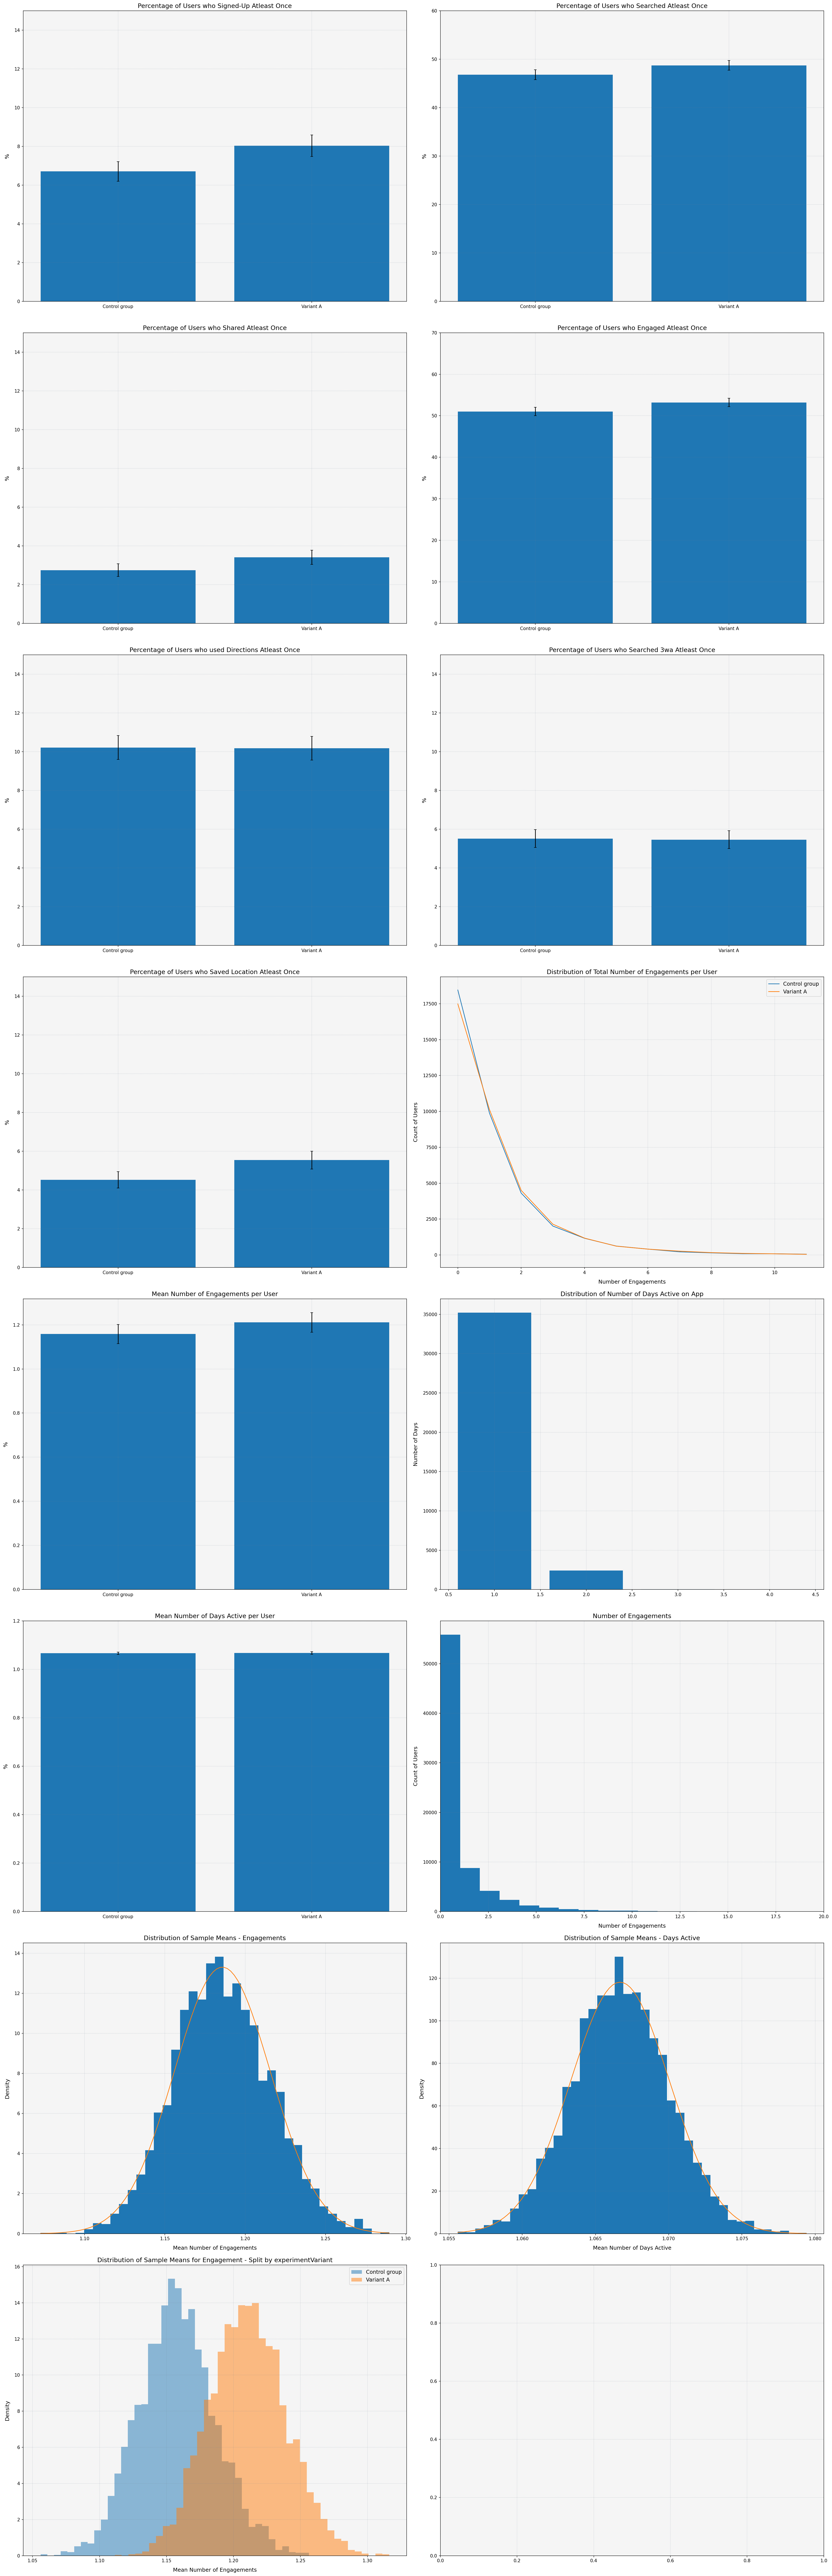

In [55]:
# Creat plots

fig, axs = plt.subplots(nrows=8,ncols=2)

axs[0,0].bar(signup_conversion.index,
             signup_conversion['Conversion_Proportion_%'],
             yerr=signup_conversion.yerr      
            )
axs[0,1].bar(search_conversion.index,
             search_conversion['Conversion_Proportion_%'],
             yerr=search_conversion.yerr      
            )

axs[1,0].bar(share_conversion.index,
             share_conversion['Conversion_Proportion_%'],
             yerr=share_conversion.yerr      
            )

axs[1,1].bar(unique_engagement_conversion.index,
             unique_engagement_conversion['Conversion_Proportion_%'],
             yerr=unique_engagement_conversion.yerr      
            )

axs[2,0].bar(directions_conversion.index,
             directions_conversion['Conversion_Proportion_%'],
             yerr=directions_conversion.yerr      
            )

axs[2,1].bar(search3wa_conversion.index,
             search3wa_conversion['Conversion_Proportion_%'],
             yerr=search3wa_conversion.yerr      
            )

axs[3,0].bar(save_location_conversion.index,
             save_location_conversion['Conversion_Proportion_%'],
             yerr=save_location_conversion.yerr      
            )

axs[3,1].plot(engagement_distribution['Control group'].head(12),
              label=('Control group')
            )
axs[3,1].plot(engagement_distribution['Variant A'].head(12),
              label=('Variant A'))
                                      

axs[4,0].bar(engagements.experimentVariant,
             engagements['mean'],
             yerr=engagements['yerr']    
            )

axs[4,1].bar(
             days_active_plot.index,
             days_active_plot['Control group']
            )

axs[5,0].bar(joined_retention.experimentVariant,
             joined_retention['mean'],
             yerr=joined_retention['yerr']    
            )

axs[5,1].hist(engagements_histogram,
              bins=100,
            )

axs[6,0].hist(engagement_sample_mean_dist['Engaged'],        
              bins=40, density=True
            )
axs[6,0].plot(x, p)



axs[6,1].hist(retention_sample_mean_dist['event_date'],        
              bins=40, density=True
            )
axs[6,1].plot(x_r, p_r)


axs[7,0].hist(control_engagement_sample_mean_dist['Engaged'],        
              bins=40, alpha=0.5, density=True, label='Control group'
            )
axs[7,0].hist(treatment_engagement_sample_mean_dist['Engaged'],        
              bins=40, alpha=0.5, density=True, label='Variant A'
            )
# Set plots

axs[0,0].set_title('Percentage of Users who Signed-Up Atleast Once')
axs[0,0].set_ylabel('%')
axs[0,0].set_ylim(0,15)

axs[0,1].set_title("Percentage of Users who Searched Atleast Once")
axs[0,1].set_ylabel('%')
axs[0,1].set_ylim(0,60)

axs[1,0].set_title('Percentage of Users who Shared Atleast Once')
axs[1,0].set_ylabel('%')
axs[1,0].set_ylim(0,15)

axs[1,1].set_title('Percentage of Users who Engaged Atleast Once')
axs[1,1].set_ylabel('%')
axs[1,1].set_ylim(0,70)

axs[2,0].set_title('Percentage of Users who used Directions Atleast Once')
axs[2,0].set_ylabel('%')
axs[2,0].set_ylim(0,15)

axs[2,1].set_title('Percentage of Users who Searched 3wa Atleast Once')
axs[2,1].set_ylabel('%')
axs[2,1].set_ylim(0,15)

axs[3,0].set_title('Percentage of Users who Saved Location Atleast Once')
axs[3,0].set_ylabel('%')
axs[3,0].set_ylim(0,15)

axs[3,1].set_title('Distribution of Total Number of Engagements per User')
axs[3,1].set_ylabel('Count of Users')
axs[3,1].set_xlabel('Number of Engagements')
axs[3,1].legend()

axs[4,0].set_title('Mean Number of Engagements per User')
axs[4,0].set_ylabel('%')

axs[4,1].set_title('Distribution of Number of Days Active on App')
axs[4,1].set_ylabel('Number of Days')

axs[5,0].set_title('Mean Number of Days Active per User')
axs[5,0].set_ylabel('%')
axs[5,0].set_ylim(0,1.2)

axs[5,1].set_title('Number of Engagements')
axs[5,1].set_ylabel('Count of Users')
axs[5,1].set_xlabel('Number of Engagements')
axs[5,1].set_xlim(0,20)

axs[6,0].set_title('Distribution of Sample Means - Engagements')
axs[6,0].set_ylabel('Density')
axs[6,0].set_xlabel('Mean Number of Engagements')

axs[6,1].set_title('Distribution of Sample Means - Days Active')
axs[6,1].set_ylabel('Density')
axs[6,1].set_xlabel('Mean Number of Days Active')

axs[7,0].set_title('Distribution of Sample Means for Engagement - Split by experimentVariant')
axs[7,0].set_ylabel('Density')
axs[7,0].set_xlabel('Mean Number of Engagements')
axs[7,0].legend()